<a href="https://colab.research.google.com/github/HiroakiMorita/jupterlab_st/blob/master/ds_210223_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import glob
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print('tf.__version__: {}'.format(tf.__version__))
print('gpu_device_name: {}'.format(tf.test.gpu_device_name()))

tf.__version__: 2.4.1
gpu_device_name: /device:GPU:0


In [ ]:
# CLASS_NAMES = ['優良', '良', '加工品', '規格外']
CLASS_NAMES = ['best', 'good', 'processed', 'non-standard']
NUM_CLASSES = len(CLASS_NAMES)

# ROOT_PATH = './Colab Notebooks'
INPUT_PATH = os.path.join('./Colab Notebooks/input')
OUTPUT_PATH = os.path.join('./Colab Notebooks/output')
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/input/train_images.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/input/test_images.csv')

In [ ]:
df_test

,id
0,test_0000.jpg
1,test_0001.jpg
2,test_0002.jpg
3,test_0003.jpg
4,test_0004.jpg
...,...
1646,test_1646.jpg
1647,test_1647.jpg
1648,test_1648.jpg
1649,test_1649.jpg


In [ ]:
INPUT_PATH

'./Colab Notebooks/input'

In [ ]:
df_train

,id,class_num
0,train_0000.jpg,0
1,train_0001.jpg,0
2,train_0002.jpg,0
3,train_0003.jpg,0
4,train_0004.jpg,0
...,...,...
1097,train_1097.jpg,1
1098,train_1098.jpg,0
1099,train_1099.jpg,1
1100,train_1100.jpg,2


In [ ]:
ls

ds_210222_1.ipynb  ds_210223_2.ipynb  output/
ds_210223_1.ipynb  input/             submission.csv


In [ ]:
train_labels = np.asarray(df_train['class_num'])
train_labels

array([0, 0, 0, ..., 1, 2, 0])

In [ ]:
def load_image_dir(path):
  img_list = []
  path_list = sorted(os.listdir(path))
  for image_name in path_list:
    img = cv2.imread(os.path.join(path, image_name), )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img , (240, 240))  # メモリ節約のためリサイズしている
    img = img / 255.0
    img_list.append(img)
  return np.asarray(img_list)

In [ ]:
train_images = load_image_dir('/content/drive/MyDrive/Colab Notebooks/input/train_images')
# print('train_images.shape: {}'.format(train_images.shape))
# train_images

In [ ]:
def display_images(images, labels=None):
  plt.figure(figsize=(10,10))
  grid_size = min(50, len(images))
  for i in range(grid_size):
    plt.subplot(5, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    if labels is not None:
      plt.xlabel(CLASS_NAMES[labels[i]])

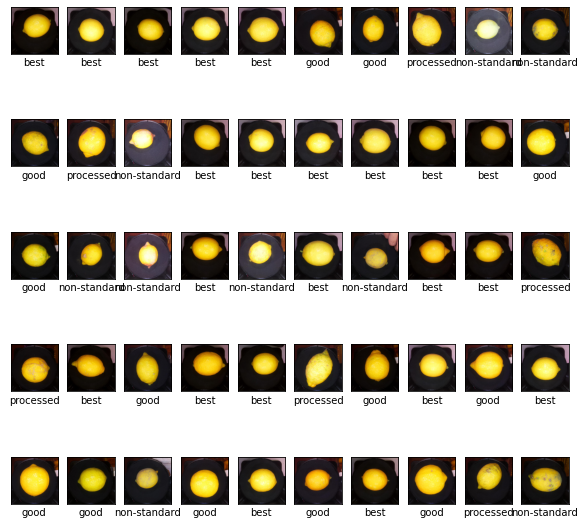

In [ ]:
display_images(train_images, train_labels)

In [ ]:
train_categorical_labels = tf.keras.utils.to_categorical(train_labels, NUM_CLASSES) #ワンホットエンコーディングしている
X_train, X_val, y_train, y_val = train_test_split(train_images, train_categorical_labels, test_size=0.3, random_state=1)
print('X_train.shape: {}'.format(X_train.shape))
print('X_val.shape: {}'.format(X_val.shape))
print('y_train.shape: {}'.format(y_train.shape))
print('y_val.shape: {}'.format(y_val.shape))

X_train.shape: (771, 300, 300, 3)
X_val.shape: (331, 300, 300, 3)
y_train.shape: (771, 4)
y_val.shape: (331, 4)


In [ ]:
train_categorical_labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

num_train_layers = 2
for i in range(len(base_model.layers)):
  tranable = True if i >= len(base_model.layers) - num_train_layers else False
  base_model.layers[i].trainable = tranable

model.compile(loss=keras.losses.categorical_crossentropy,
              # optimizer="rmsprop",
              optimizer="Adamax",
              metrics=['accuracy'])
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [ ]:
batch_size = 128
epochs = 50

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[early_stopping])

Epoch 1/50
7/7 [==============================] - 24s 2s/step - loss: 1.6949 - accuracy: 0.3083 - val_loss: 1.2815 - val_accuracy: 0.5196
Epoch 2/50
7/7 [==============================] - 7s 1s/step - loss: 1.1616 - accuracy: 0.5875 - val_loss: 0.8965 - val_accuracy: 0.7039
Epoch 3/50
7/7 [==============================] - 7s 1s/step - loss: 0.8473 - accuracy: 0.6974 - val_loss: 0.7683 - val_accuracy: 0.6012
Epoch 4/50
7/7 [==============================] - 7s 1s/step - loss: 0.6794 - accuracy: 0.6908 - val_loss: 0.6184 - val_accuracy: 0.6707
Epoch 5/50
7/7 [==============================] - 7s 1s/step - loss: 0.6003 - accuracy: 0.6910 - val_loss: 0.5622 - val_accuracy: 0.7885
Epoch 6/50
7/7 [==============================] - 7s 1s/step - loss: 0.5011 - accuracy: 0.8507 - val_loss: 0.5182 - val_accuracy: 0.8550
Epoch 7/50
7/7 [==============================] - 7s 1s/step - loss: 0.4626 - accuracy: 0.8353 - val_loss: 0.4870 - val_accuracy: 0.8338
Epoch 8/50
7/7 [========================

In [ ]:
test_images = load_image_dir('/content/drive/MyDrive/Colab Notebooks/input/test_images')

In [ ]:
print('test_images.shape: {}'.format(test_images.shape))

NameError: ignored

In [ ]:
pred = model.predict(test_images)

In [ ]:
pred_list = []
for i, p in enumerate(pred):
  pred_list.append(np.argmax(p))

df_test['pred'] = pred_list
df_test.head()

,id,pred
0,test_0000.jpg,0
1,test_0001.jpg,3
2,test_0002.jpg,0
3,test_0003.jpg,3
4,test_0004.jpg,0


In [ ]:
df_test.to_csv(os.path.join('/content/drive/MyDrive/Colab Notebooks/output/submit_210223_1.csv'), header=None, columns=['id', 'pred'], index=None)